In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
print("All modules have been imported")

All modules have been imported


In [2]:
from PIL import Image
import glob


x = []
for filename in sorted(glob.glob("all-mias/*.pgm")):
    img = cv2.imread(filename)  # Load and resize image
    img = cv2.resize(img, (224, 224))
    x.append(img)

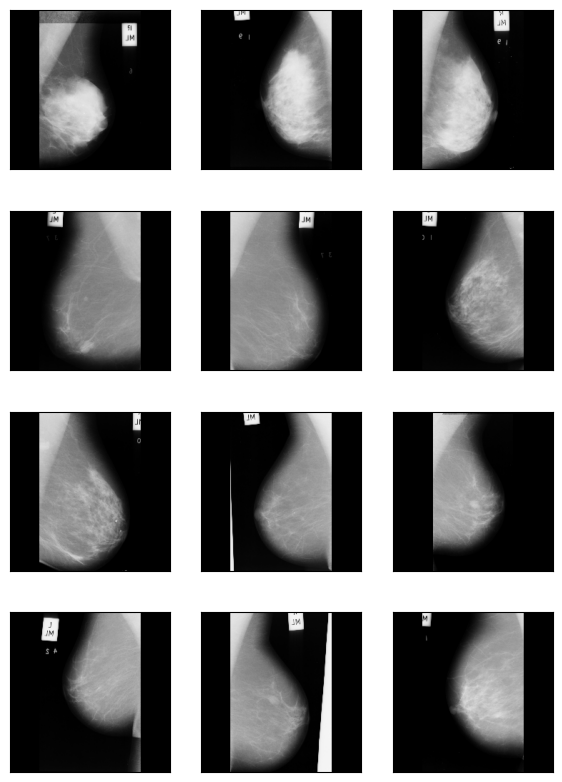

In [3]:
fig = plt.figure(figsize=(7, 10))


columns = 3
rows = 4


for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
    plt.xticks([]), plt.yticks([]) 


plt.show()

In [4]:
no_angles = 360 
url = 'all-mias/' 

In [5]:
def read_image():
    """Read and preprocess images."""
    print("Reading images")
    import cv2
    
    info = {}  
    for i in range(322):  
       
        if i < 9:
            image_name = 'mdb00' + str(i + 1)
        elif i < 99:
            image_name = 'mdb0' + str(i + 1)
        else:
            image_name = 'mdb' + str(i + 1)
            
        image_address = url + image_name + '.pgm'
        img = cv2.imread(image_address, 0) 
        img = cv2.resize(img, (64, 64)) 
        rows, cols = img.shape
        
        info[image_name] = {}
        for angle in range(0, no_angles, 2):  
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle] = img_rotated
            
    return info

In [6]:
def read_label():
    """Read labels from file."""
    print("Reading labels")
    filename = url + 'Info.txt'
    text_all = open(filename).read()
    lines = text_all.split('\n')
    info = {}  # Dictionary for label data
    
    for line in lines:
        words = line.split(' ')
        if len(words) > 3:
            if (words[3] == 'B'):  # Label 'B' for benign
                info[words[0]] = {angle: 0 for angle in range(0, no_angles, 2)}  # Assigning label 0 for benign
            if (words[3] == 'M'):  # Label 'M' for malignant
                info[words[0]] = {angle: 1 for angle in range(0, no_angles, 2)}  # Assigning label 1 for malignant

    return info

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Read data
label_info = read_label()
image_info = read_image()
ids = label_info.keys()

# Remove 'Truth-Data:' from label information
del label_info['Truth-Data:']

X, Y = [], []
for id in ids:
    for angle in range(0, no_angles, 2):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=2021)

# Reshape x_train and x_test to include a channel dimension
x_train = np.reshape(x_train, (*x_train.shape, 1))
x_test = np.reshape(x_test, (*x_test.shape, 1))

print('xtrain shape=', x_train.shape)
print('xtest shape=', x_test.shape)

Reading labels
Reading images
xtrain shape= (17595, 64, 64, 1)
xtest shape= (3105, 64, 64, 1)


In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
rows, cols, color = x_train[0].shape


In [9]:
def build_model(hp):
    # Initialize a sequential model
    model = Sequential()
    
    # Add the first convolutional layer with hyperparameter search for number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),  # Search between 32 and 128 filters with a step of 32
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),  # Choose between kernel sizes of 3 and 5
        padding='same',
        strides=(1, 1),
        input_shape=(rows,cols,1)
    ))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
    # Add the second convolutional layer with hyperparameter search for number of filters
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), kernel_size=(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    # Add dropout with hyperparameter search for dropout rate
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Continue with model layers (without hyperparameter tuning for simplicity due to limited computational capacity)
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model with hyperparameter search for learning rate
    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner RandomSearch optimizer
tuner = RandomSearch(
    build_model,  # The model-building function
    objective='val_accuracy',  # Objective to optimize
    max_trials=5,  # Max number of hyperparameter combinations to try
    executions_per_trial=3,  # Number of times to train each model to average out the performance
    directory='random_search',  # Directory to save results
    project_name='Hyperparameter Search'  # Name of the project
)

# Search for the best hyperparameters using the training data
tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

# Retrieve the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of filters in the first convolutional layer is {best_hyperparameters.get('conv_1_filter')},
As for second convolutional layer, the optimal number of filters is {best_hyperparameters.get('conv_2_filter')}, 
The optimal dropout value for the second layers is {best_hyperparameters.get('dropout_2')}
and the optimal learning rate for the optimizer is {best_hyperparameters.get('learning_rate')}.
---------------------------------------------------------------------------------------------------------------
You can go ahead to do a full scale training of the model applying these optimized hyperparameters.
""")

Reloading Tuner from random_search\Hyperparameter Search\tuner0.json



C:\Users\sauma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(



The hyperparameter search is complete. 
The optimal number of filters in the first convolutional layer is 96,
As for second convolutional layer, the optimal number of filters is 48, 
The optimal dropout value for the second layers is 0.0
and the optimal learning rate for the optimizer is 0.0001.
---------------------------------------------------------------------------------------------------------------
You can go ahead to do a full scale training of the model applying these optimized hyperparameters.



C:\Users\sauma\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [10]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 96)          │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 48)          │          41,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          55,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 339,313 (1.29 MB)

 Trainable params: 339,313 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(x_train,
                         y_train,validation_split=0.2,
                         epochs=100
                         ,shuffle=True,
                         batch_size=128,
                         callbacks=[es])

loss_value , accuracy = best_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9875 - loss: 0.0351 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9864 - loss: 0.0397 - val_accuracy: 0.9986 - val_loss: 0.0068
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9890 - loss: 0.0355 - val_accuracy: 0.9989 - val_loss: 0.0062
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9868 - loss: 0.0396 - val_accuracy: 0.9974 - val_loss: 0.0075
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9863 - loss: 0.0357 - val_accuracy: 0.9980 - val_loss: 0.0062
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9872 - loss: 0.0350 - val_accuracy: 0.9991 - val_loss: 0.0047
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9893 - loss: 0.0333 - val_accuracy: 0.9989 - val_loss: 0.0047
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9889 - loss: 0.0311 - 

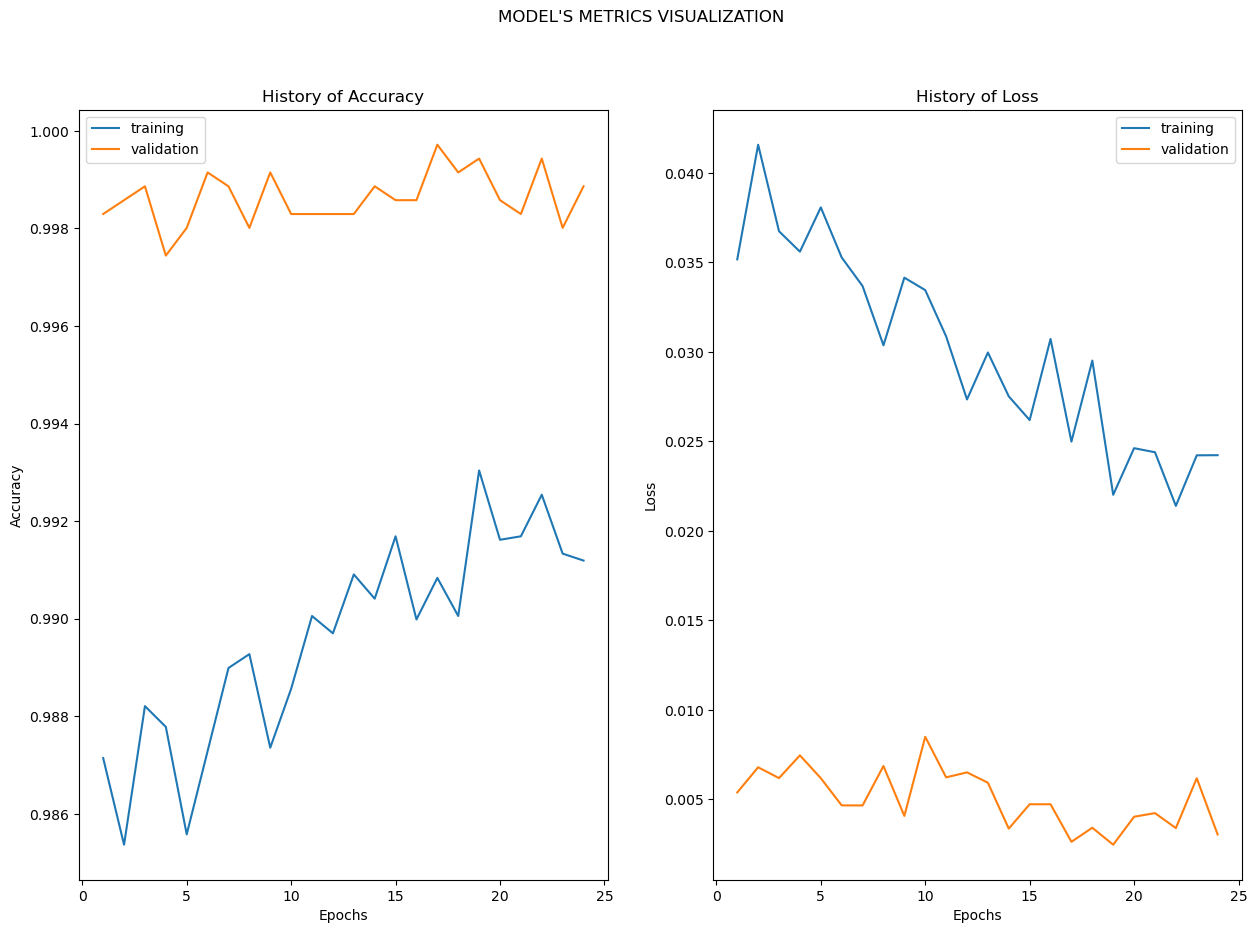

In [14]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Plot accuracy history
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    # Plot loss history
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    plt.show()

Train_Val_Plot(
    history.history['accuracy'],
    history.history['val_accuracy'],
    history.history['loss'],
    history.history['val_loss']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


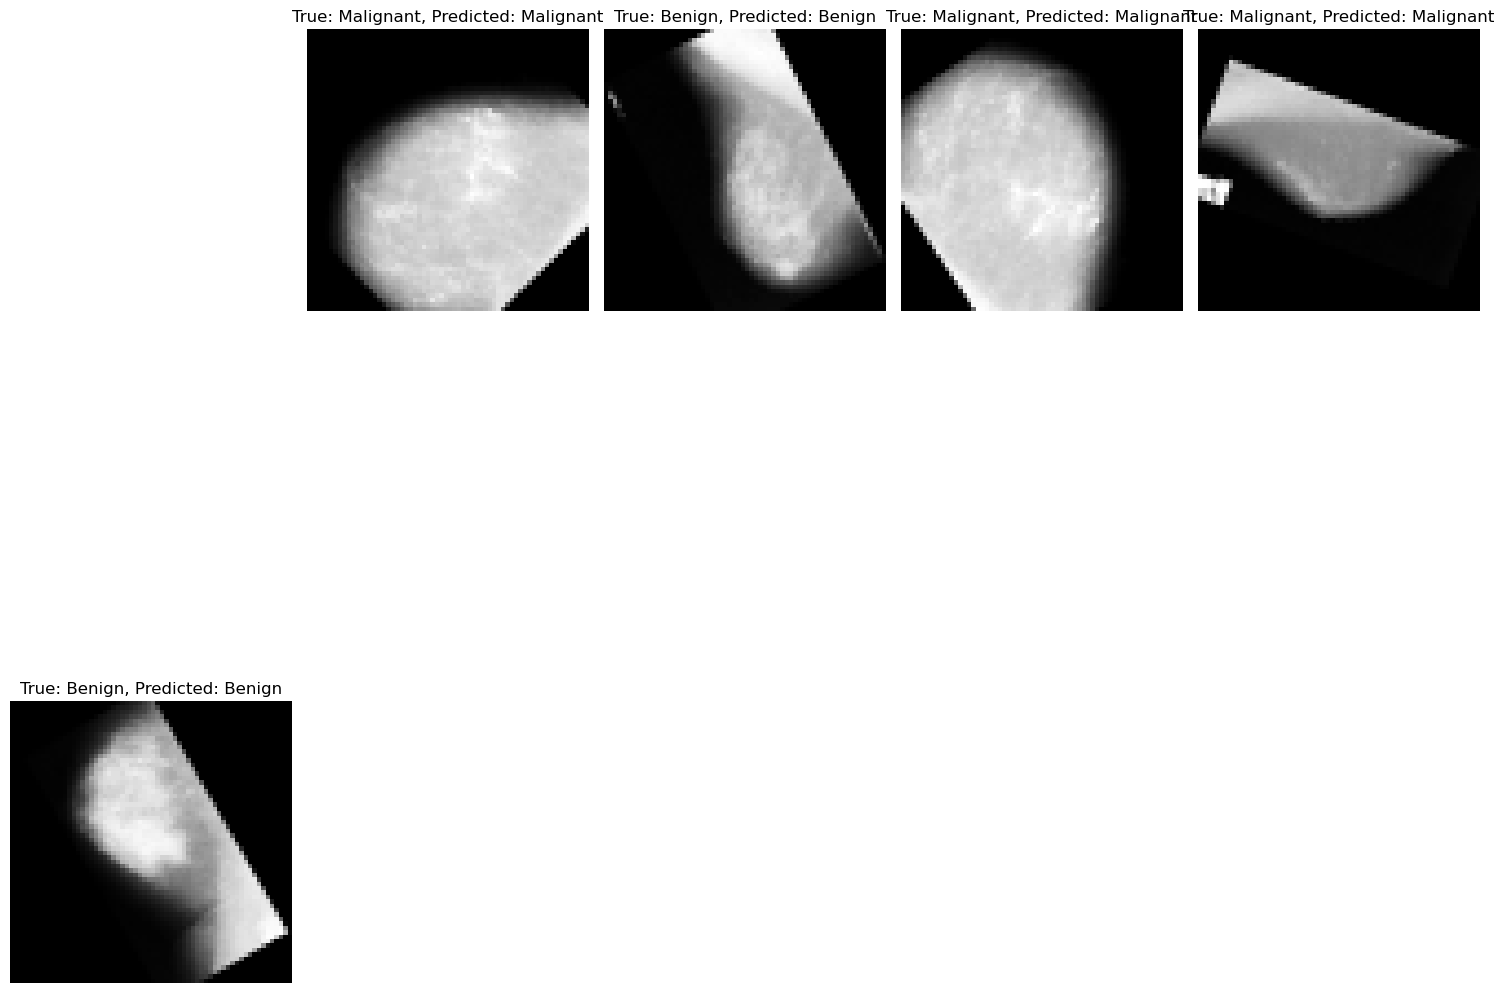

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images and their classifications
def display_images_with_predictions(images, labels_true, model):
    num_images = len(images)
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = num_images // columns + 1
    
    label_mapping = {0: "Benign", 1: "Malignant"}  # Define mapping for numeric labels to categories
    
    for i in range(num_images):
        img = images[i]
        label_true = labels_true[i]
        
        # Predict using the model
        img_input = np.expand_dims(img, axis=0)  # Add batch dimension
        prediction = model.predict(img_input)
        label_predicted = int(np.round(prediction)[0][0])  # Convert prediction to integer label
        predicted_category = label_mapping[label_predicted]  # Map predicted label to category
        
        # Display the image
        ax = fig.add_subplot(rows, columns, i + 2)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {label_mapping[label_true]}, Predicted: {predicted_category}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Select 5 random images from the test set
num_images_to_display = 5
random_indices = np.random.choice(len(x_test), num_images_to_display, replace=False)
sample_images = x_test[random_indices]
sample_labels_true = y_test[random_indices]

# Display the sample images with predictions
display_images_with_predictions(sample_images, sample_labels_true, best_model)
